In [11]:
from genomic_embeddings import Embeddings

In [12]:
model_path = "/home/toibazd/Data/outputs/G2V/G2V_2024-01-16.w2v"
gene_embeddings = Embeddings.load_embeddings(model_path)

In [15]:
import pandas as pd


df = pd.read_csv('KOs_with_labels.csv')
df['embeddings'] = pd.Series(dtype=object)

def your_embedding_function(ko):
    return gene_embeddings.wv[ko]

# Apply the embedding function to fill the 'embeddings' column
df['embeddings'] = df['KOs'].apply(lambda ko: your_embedding_function(ko) if ko in gene_embeddings.wv else None)
df = df.dropna()
df = df.drop(columns=["Unnamed: 0"])


In [16]:
df.to_csv("KOs_with_labels_for_W2V.csv", index = False)

In [18]:
import torch
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        return self.fc4(self.dropout(self.relu(self.fc3(self.dropout(self.relu(self.fc2(self.dropout(self.relu(self.fc1(x))))))))))

input_dim = 300
first_hidden = 256
second_hidden = 128
last_hidden = 64
output_dim = 9
dropout_prob = 0.2

model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [19]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
print(device)

cuda


In [20]:
model.to(device)

Classification_V0(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=9, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [21]:
print(len(df))

5448


In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder




label_to_int = {label: i for i, label in enumerate(df['label'].unique())}

num_classes = len(label_to_int)
df['label_int'] = df['label'].map(label_to_int)
label_int_array = df['label_int'].to_numpy()
len(label_int_array)

5448

In [23]:
len(df[df['label'] == 'Ribosome'])

469

In [24]:
X = df['embeddings'].to_numpy()

In [25]:
label_int_array[:10]

array([0, 0, 1, 0, 0, 2, 0, 0, 3, 4])

In [26]:
class Word2vecdataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y      
        self.len = X.shape[0] 

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
    
        X_idx = self.X[idx, :]
        y_idx = self.y[idx]
        return X_idx, y_idx

In [27]:
train_X, test_X, train_y, test_y = train_test_split(X, label_int_array, test_size=0.2, random_state=42, stratify=label_int_array)

train_X=np.vstack(train_X)
test_X=np.vstack(test_X)


In [28]:
train_X.shape, test_X.shape

((4358, 300), (1090, 300))

In [29]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')

y_1hot = encoder.fit_transform(train_y.reshape(-1,1))

In [30]:
x_train = torch.tensor(train_X, dtype=torch.float)
x_test = torch.tensor(test_X, dtype=torch.float)
y_train = torch.tensor(y_1hot, dtype=torch.float)
y_test = torch.tensor(test_y, dtype=torch.float)

In [31]:
train_dataset = Word2vecdataset(x_train, y_train)
test_dataset = Word2vecdataset(x_test, y_test)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

In [33]:
model.train()
losses = []

for i in range(30):
    loss_epoch = 0
    print(f"Training at {i+1} epoch")
    for index, data in enumerate(train_loader):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss_epoch+=loss.item()
        loss.backward()
        optimizer.step()
    print("Loss: ",loss_epoch/len(train_loader), end="\n\n")
    losses.append(loss_epoch/len(train_loader))
    
print("Finished training")

Training at 1 epoch
Loss:  1.986364944137796

Training at 2 epoch
Loss:  1.940879703438195

Training at 3 epoch
Loss:  1.9352500186349353

Training at 4 epoch
Loss:  1.9375853094741375

Training at 5 epoch
Loss:  1.940757959428495

Training at 6 epoch
Loss:  1.93856964407176

Training at 7 epoch
Loss:  1.9375647619692948

Training at 8 epoch
Loss:  1.9359069601462706

Training at 9 epoch
Loss:  1.9320644984280106

Training at 10 epoch
Loss:  1.9325037272307124

Training at 11 epoch
Loss:  1.9274825397199087

Training at 12 epoch
Loss:  1.9313164375124185

Training at 13 epoch
Loss:  1.9243387210108067

Training at 14 epoch
Loss:  1.9189149558979228

Training at 15 epoch
Loss:  1.9152866445318626

Training at 16 epoch
Loss:  1.9137994520855646

Training at 17 epoch
Loss:  1.9080954633490013

Training at 18 epoch
Loss:  1.907215961574638

Training at 19 epoch
Loss:  1.9097990337079458

Training at 20 epoch
Loss:  1.9067111363376144

Training at 21 epoch
Loss:  1.9082157724965227

Trainin

In [34]:
model.eval()
with torch.inference_mode():
    outputs = model(x_test.to(device))
    predictions = torch.argmax(torch.softmax(outputs, dim=-1), dim=1)
    correct = torch.eq(y_test, predictions.cpu()).sum().item()
    print(correct)
    acc = (correct / len(y_test)) * 100
    print("Classification accuracy: ", acc)

315
Classification accuracy:  28.899082568807337


In [35]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions.cpu(), target_names=label_to_int.keys())
print(report)

                                             precision    recall  f1-score   support

                                   Ribosome       0.00      0.00      0.00        94
                 Prokaryotic defense system       0.00      0.00      0.00       173
       Porphyrin and chlorophyll metabolism       0.00      0.00      0.00        54
                  Oxidative phosphorylation       0.00      0.00      0.00        82
Amino sugar and nucleotide sugar metabolism       0.00      0.00      0.00        62
                           Secretion system       0.29      0.99      0.45       317
                       Two-component system       0.20      0.01      0.02       233
                          Energy metabolism       0.00      0.00      0.00        42
                       Benzoate degradation       0.00      0.00      0.00        33

                                   accuracy                           0.29      1090
                                  macro avg       0.05      0.1

/home/toibazd/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toibazd/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toibazd/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print(label_to_int)

{'Ribosome': 0, 'Prokaryotic defense system': 1, 'Porphyrin and chlorophyll metabolism': 2, 'Oxidative phosphorylation': 3, 'Amino sugar and nucleotide sugar metabolism': 4, 'Secretion system': 5, 'Two-component system': 6, 'Energy metabolism': 7, 'Benzoate degradation': 8}


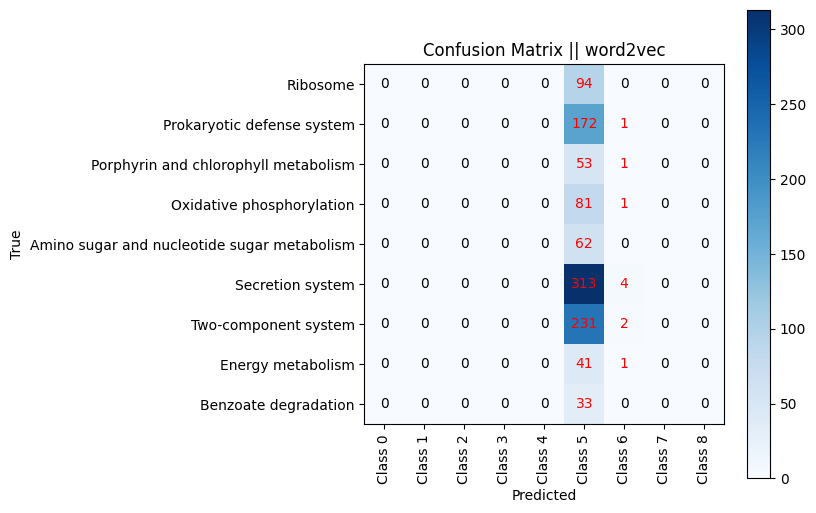

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the tensors to NumPy arrays
y_true = y_test.cpu().numpy()  # Convert to NumPy and move to CPU if using GPU
y_pred = predictions.cpu().numpy()

# Create an empty confusion matrix
confusion_matrix = np.zeros((len(label_to_int), len(label_to_int)))

# Fill in the confusion matrix
for i in range(len(y_true)):
    true_class = int(y_true[i])
    pred_class = int(y_pred[i])
    confusion_matrix[true_class, pred_class] += 1

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix || word2vec')
plt.colorbar()

tick_marks = np.arange(len(label_to_int))
plt.xticks(tick_marks, [f'Class {i}' for i in range(len(label_to_int))], rotation=90)
plt.yticks(tick_marks, list(label_to_int.keys()))

for i in range(len(label_to_int)):
    for j in range(len(label_to_int)):
        plt.text(j, i, f'{int(confusion_matrix[i, j]):d}', ha='center', va='center', color='red' if confusion_matrix[i, j] > 0.5 else 'black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("Results/Confmat_word2vec.jpg")
plt.show()



In [38]:
print(torch.sum(y_test == 0).item())
print(torch.sum(y_test == 1).item())
print(torch.sum(y_test == 2).item())
print(torch.sum(y_test == 3).item())
print(torch.sum(y_test == 4).item())
print(torch.sum(y_test == 5).item())
print(torch.sum(y_test == 6).item())
print(torch.sum(y_test == 7).item())
print(torch.sum(y_test == 8).item())

label_to_int

94
173
54
82
62
317
233
42
33


{'Ribosome': 0,
 'Prokaryotic defense system': 1,
 'Porphyrin and chlorophyll metabolism': 2,
 'Oxidative phosphorylation': 3,
 'Amino sugar and nucleotide sugar metabolism': 4,
 'Secretion system': 5,
 'Two-component system': 6,
 'Energy metabolism': 7,
 'Benzoate degradation': 8}

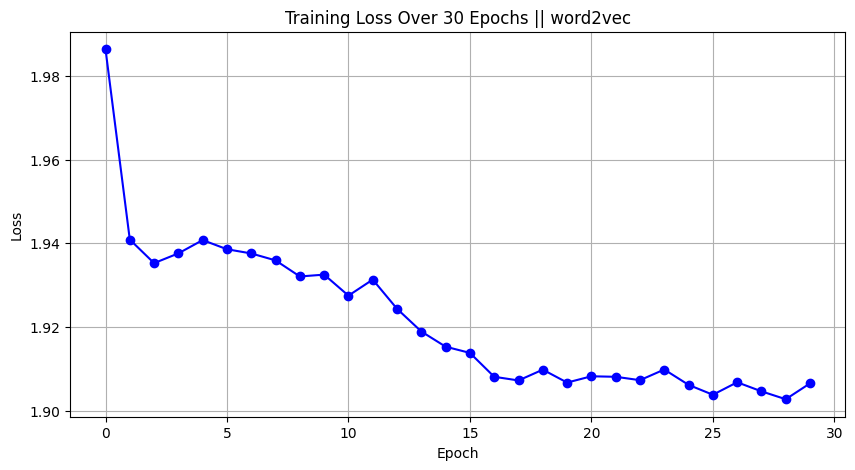

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
plt.title(f'Training Loss Over {len(losses)} Epochs || word2vec')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig("Results/Training_loss_word2vec.png")
plt.show()